# CNN Model

Our goal: Improve the yield of wafer manufacturing processes in semiconductor fabrication by automatically identifying different types of wafer map failure patterns instead of manual work.

Data: WM-811K wafer map

Installation and Setup

In [1]:
# loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import os
from os.path import join
path = "C:/Users/ASUS/Thesis/Dataset"
print(os.listdir(path))
import warnings
warnings.filterwarnings("ignore")

['LSWMD.pkl']


Data Summary

In [2]:
df=pd.read_pickle("C:/Users/ASUS/Thesis/Dataset/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


Data set composition

811,457 sets

1. wafer map
2. wafer die size
3. Lot name
4. wafer index


In [3]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [4]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


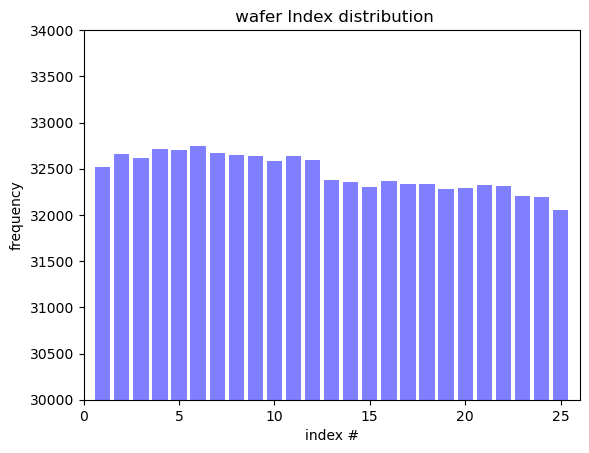

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='blue', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

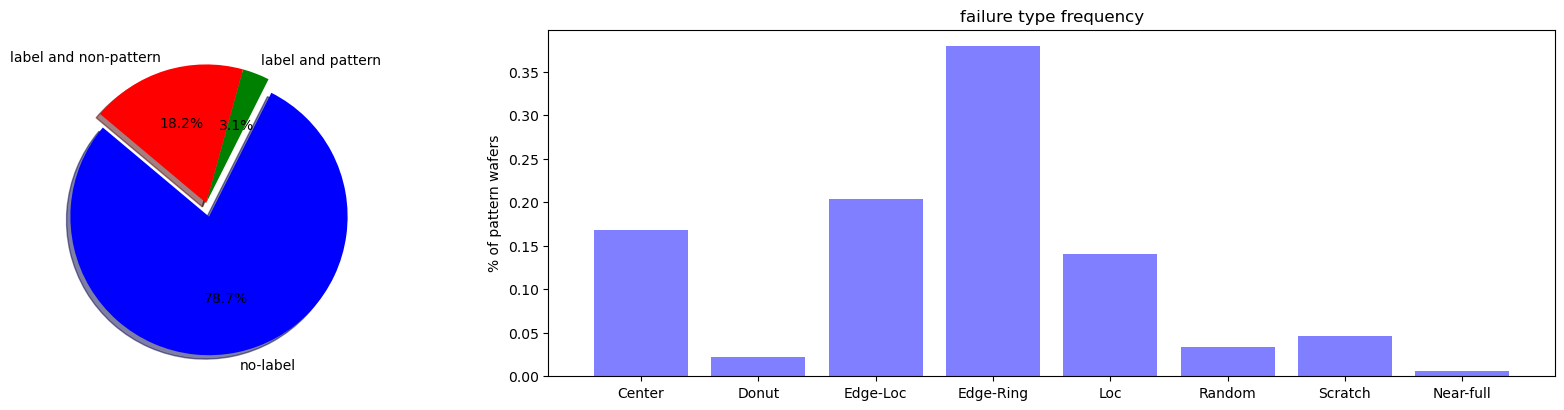

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

tol_wafers = df.shape[0]
tol_wafers

df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['blue', 'green', 'red']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label and pattern','label and non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='blue', align='center', alpha=0.5)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

# Save the confusion matrix image
plt.savefig('Failure.png')
plt.show()

In [7]:
df = df.drop(['waferIndex'], axis = 1)

We don't get much information from the wafer map column, but we can see that each instance has a different die size.

For wafer map dim inspection

Create 'waferMap Dim" variable.

In [8]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,failureNum,trainTestNum,waferMapDim
711579,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",516.0,lot43490,[[Test]],[[none]],8,1,"(25, 27)"
51740,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot4212,[],[],[],[],"(32, 29)"
386157,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1334.0,lot23140,[],[],[],[],"(41, 42)"
627758,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot39424,[],[],[],[],"(32, 29)"
31572,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot3102,[],[],[],[],"(30, 34)"


Wafer resolution (26, 26)
Arrange wafers and arrays with Footly Case labels;
Some wafer labels are null and omitted.

In [9]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [10]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [11]:
# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


plot 1st data for check.

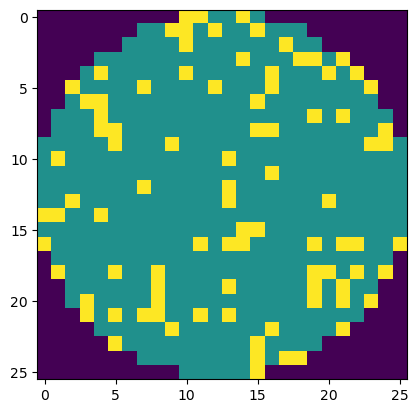

Faulty case : ['none'] 


In [12]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

Using 2D Convolutional Autoencoder with expanded dimensionality.


In [13]:
#add channel
x = x.reshape((-1, 26, 26, 1))

Create defective type list, check defective type

In [14]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [15]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [16]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [17]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

Data expansion is necessary to solve the problem of data inconsistency. Since wafer data is image data, Convolutional Autoencoder is used.






In [18]:
# parameter
epoch=15
batch_size=1024

In [19]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [20]:
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 13, 13, 64)       36928     
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 26, 26, 64)       0         
 )                                                               
                                                             

In [21]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/15
15/15 - 17s - loss: 0.1525 - 17s/epoch - 1s/step
Epoch 2/15
15/15 - 18s - loss: 0.0965 - 18s/epoch - 1s/step
Epoch 3/15
15/15 - 18s - loss: 0.0840 - 18s/epoch - 1s/step
Epoch 4/15
15/15 - 15s - loss: 0.0727 - 15s/epoch - 975ms/step
Epoch 5/15
15/15 - 15s - loss: 0.0633 - 15s/epoch - 984ms/step
Epoch 6/15
15/15 - 15s - loss: 0.0560 - 15s/epoch - 1s/step
Epoch 7/15
15/15 - 18s - loss: 0.0500 - 18s/epoch - 1s/step
Epoch 8/15
15/15 - 18s - loss: 0.0447 - 18s/epoch - 1s/step
Epoch 9/15
15/15 - 17s - loss: 0.0393 - 17s/epoch - 1s/step
Epoch 10/15
15/15 - 15s - loss: 0.0345 - 15s/epoch - 1s/step
Epoch 11/15
15/15 - 15s - loss: 0.0305 - 15s/epoch - 974ms/step
Epoch 12/15
15/15 - 14s - loss: 0.0272 - 14s/epoch - 952ms/step
Epoch 13/15
15/15 - 14s - loss: 0.0245 - 14s/epoch - 952ms/step
Epoch 14/15
15/15 - 15s - loss: 0.0223 - 15s/epoch - 985ms/step
Epoch 15/15
15/15 - 14s - loss: 0.0205 - 14s/epoch - 960ms/step


Creating an encoder model as part of the autocoder model layer

In [22]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

Creating a decoder model as part of the autocoder model layer

In [23]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

Original defect wafer encoding

In [24]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

449/449 [==============================] - 2s 4ms/step


Adding noise to the encoded potential defect wafer vector

In [25]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

Check the original defect wafer data

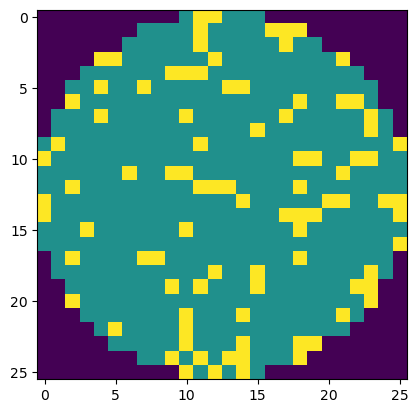

In [26]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

New noise defect wafer data verification

449/449 [==============================] - 5s 11ms/step


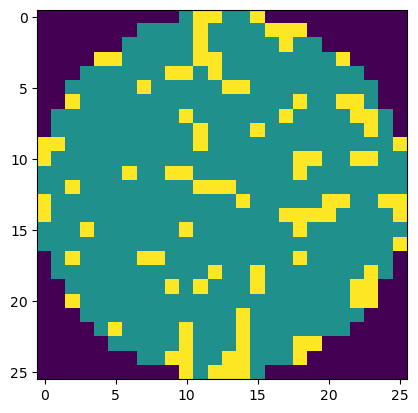

In [27]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

Check reconstructed original defective wafer data

449/449 [==============================] - 6s 13ms/step


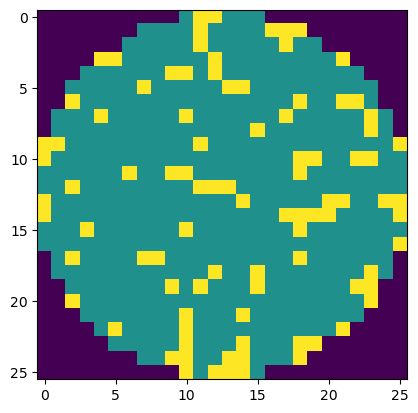

In [28]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(ae.predict(new_x), axis=3)
plt.imshow(gen_x[3])

The data for all defective cases will be expanded in the same way as above, with data containing 2000 samples for each case.

In [29]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)

    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))

    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)

    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [30]:
# Augmentation for all faulty case.
for f in faulty_case :
    # skip none case
    if f == 'none' :
        continue

    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

3/3 [==============================] - 0s 14ms/step


In [31]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [32]:
# choice index without replace.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [33]:
# delete choiced index data.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [34]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [35]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [36]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i

# one-hot-encoding
new_y = to_categorical(new_y)


In [37]:
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [38]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (13203, 26, 26, 3), y : (13203, 9)
Test x: (6504, 26, 26, 3), y : (6504, 9)


Simple 2D CNN Model
Since wafer data is image, CNN model is used for classification.

Define the model generation function, and Sklearn will cross-validate the model

In [39]:
from keras import layers
from keras import models
from keras.layers import Input
from keras.utils import plot_model  # For visualization (optional)

def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_tensor)
    conv_1 = layers.Dropout(0.2)(conv_1)  # Add dropout after first convolutional layer

    conv_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv_1)
    conv_2 = layers.Dropout(0.2)(conv_2)  # Add dropout after second convolutional layer

    conv_3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv_2)
    conv_3 = layers.Dropout(0.2)(conv_3)  # Add dropout after third convolutional layer

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_1 = layers.Dropout(0.4)(dense_1)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    dense_2 = layers.Dropout(0.4)(dense_2)

    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        448       
                                                                 
 dropout (Dropout)           (None, 26, 26, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        9280      
                                                                 
 dropout_1 (Dropout)         (None, 26, 26, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 dropout_2 (Dropout)         (None, 26, 26, 128)       0   

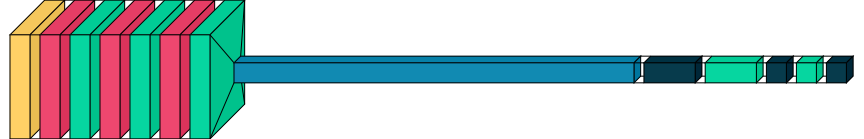

In [40]:
from keras.utils import plot_model

# Define your CNN model
model = create_model()

# Display model summary
model.summary()

import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)


In [41]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=1024, verbose=2)

# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019)
results = cross_val_score(model, x_train, y_train, cv=kfold)

# Check 3-fold model's mean accuracy
print('CNN Cross validation score : {:.4f}'.format(np.mean(results)), '\n')

Epoch 1/25
9/9 - 64s - loss: 2.2886 - accuracy: 0.2419 - 64s/epoch - 7s/step
Epoch 2/25
9/9 - 62s - loss: 1.3902 - accuracy: 0.4531 - 62s/epoch - 7s/step
Epoch 3/25
9/9 - 62s - loss: 0.9613 - accuracy: 0.6383 - 62s/epoch - 7s/step
Epoch 4/25
9/9 - 62s - loss: 0.6717 - accuracy: 0.7531 - 62s/epoch - 7s/step
Epoch 5/25
9/9 - 63s - loss: 0.4842 - accuracy: 0.8242 - 63s/epoch - 7s/step
Epoch 6/25
9/9 - 61s - loss: 0.3690 - accuracy: 0.8770 - 61s/epoch - 7s/step
Epoch 7/25
9/9 - 63s - loss: 0.2776 - accuracy: 0.9075 - 63s/epoch - 7s/step
Epoch 8/25
9/9 - 61s - loss: 0.2193 - accuracy: 0.9290 - 61s/epoch - 7s/step
Epoch 9/25
9/9 - 62s - loss: 0.1629 - accuracy: 0.9480 - 62s/epoch - 7s/step
Epoch 10/25
9/9 - 63s - loss: 0.1328 - accuracy: 0.9564 - 63s/epoch - 7s/step
Epoch 11/25
9/9 - 63s - loss: 0.1018 - accuracy: 0.9649 - 63s/epoch - 7s/step
Epoch 12/25
9/9 - 63s - loss: 0.0770 - accuracy: 0.9763 - 63s/epoch - 7s/step
Epoch 13/25
9/9 - 63s - loss: 0.0579 - accuracy: 0.9817 - 63s/epoch - 7s/

In [42]:
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=25,
                    batch_size=1024
                   )

Epoch 1/25
13/13 - 101s - loss: 2.0434 - accuracy: 0.2465 - val_loss: 1.3970 - val_accuracy: 0.4273 - 101s/epoch - 8s/step
Epoch 2/25
13/13 - 100s - loss: 1.2754 - accuracy: 0.5037 - val_loss: 0.7575 - val_accuracy: 0.7283 - 100s/epoch - 8s/step
Epoch 3/25
13/13 - 100s - loss: 0.8006 - accuracy: 0.6953 - val_loss: 0.4645 - val_accuracy: 0.8326 - 100s/epoch - 8s/step
Epoch 4/25
13/13 - 101s - loss: 0.5219 - accuracy: 0.8100 - val_loss: 0.2763 - val_accuracy: 0.9067 - 101s/epoch - 8s/step
Epoch 5/25
13/13 - 102s - loss: 0.3397 - accuracy: 0.8807 - val_loss: 0.1788 - val_accuracy: 0.9428 - 102s/epoch - 8s/step
Epoch 6/25
13/13 - 101s - loss: 0.2320 - accuracy: 0.9210 - val_loss: 0.1219 - val_accuracy: 0.9674 - 101s/epoch - 8s/step
Epoch 7/25
13/13 - 99s - loss: 0.1611 - accuracy: 0.9484 - val_loss: 0.0699 - val_accuracy: 0.9768 - 99s/epoch - 8s/step
Epoch 8/25
13/13 - 102s - loss: 0.1034 - accuracy: 0.9650 - val_loss: 0.0411 - val_accuracy: 0.9877 - 102s/epoch - 8s/step
Epoch 9/25
13/13 -

In [43]:
# Print the results 
print('3-Fold Cross Validation Results - ')
print('Mean Accuracy: {:.4f}'.format(np.mean(results)))
print('Standard Deviation: {:.4f}'.format(np.std(results)))
# Print individual fold scores (optional)
print('Individual fold scores:', results)

3-Fold Cross Validation Results - 
Mean Accuracy: 0.9905
Standard Deviation: 0.0004
Individual fold scores: [0.99022949 0.99022949 0.9911384 ]


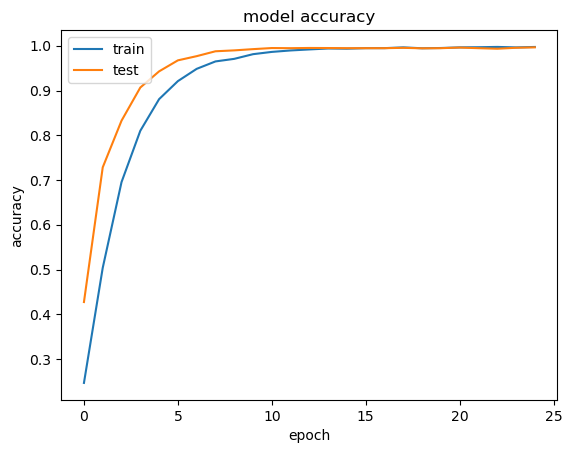

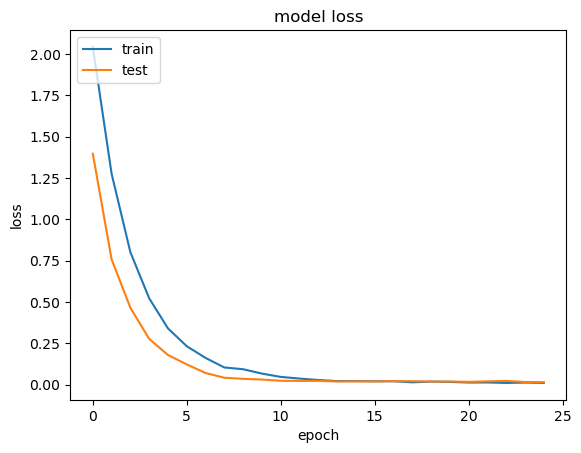

In [44]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the confusion matrix image
plt.savefig('validation.png')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the confusion matrix image
plt.savefig('loss.png')
plt.show()
plt.show()

In [45]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

7/7 - 11s - loss: 0.0146 - accuracy: 0.9965 - 11s/epoch - 2s/step
Testing Accuracy: 0.9964637160301208


In [46]:
# Make predictions on test data
y_pred = model.predict(x_test)
print("Shape of y_pred:", y_pred.shape)
print("Shape of y_test:", y_test.shape)

204/204 [==============================] - 17s 84ms/step
Shape of y_pred: (6504,)
Shape of y_test: (6504, 9)


In [47]:
from sklearn.metrics import classification_report

# Convert one-hot encoded labels back to categorical labels for y_test
y_test_classes = np.argmax(y_test, axis=1)

# Define your actual class labels
faulty_case = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']

# Generate classification report with numerical labels
report = classification_report(y_test_classes, y_pred)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       721
           1       1.00      1.00      1.00       672
           2       1.00      0.99      0.99       753
           3       0.99      1.00      1.00       668
           4       1.00      0.99      0.99       788
           5       1.00      1.00      1.00       697
           6       1.00      1.00      1.00       689
           7       1.00      1.00      1.00       678
           8       0.99      1.00      0.99       838

    accuracy                           1.00      6504
   macro avg       1.00      1.00      1.00      6504
weighted avg       1.00      1.00      1.00      6504



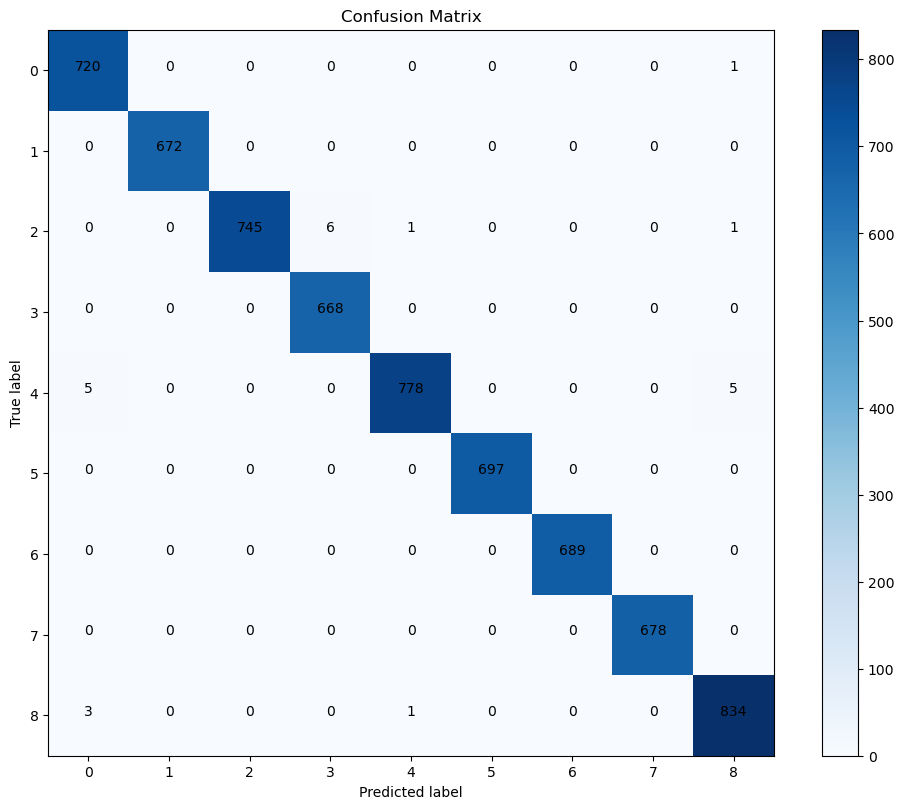

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert one-hot encoded labels back to categorical labels for y_test
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = y_pred

# Get class labels
labels = np.unique(np.concatenate((y_test_classes, y_pred_classes)))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Display values in cells
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center", color="black")

# Save the confusion matrix image
plt.savefig('confusion_matrix.png')

plt.show()


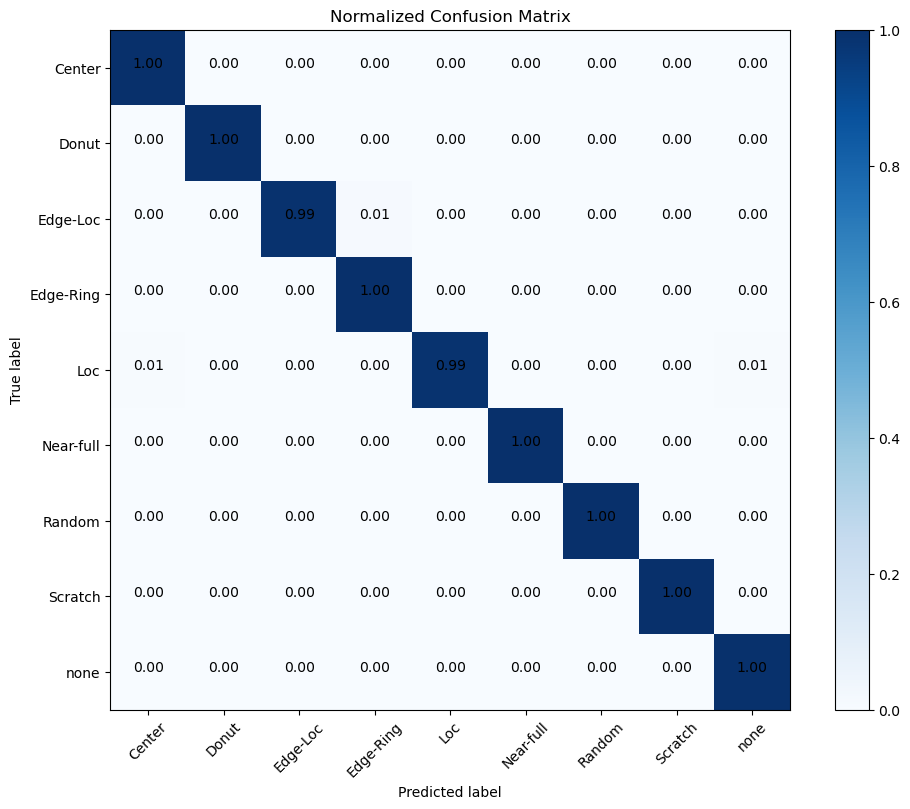

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix_normalized, cmap='Blues', interpolation='nearest')
plt.title('Normalized Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(faulty_case))
plt.xticks(tick_marks, faulty_case, rotation=45)
plt.yticks(tick_marks, faulty_case)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Display values in cells
for i in range(len(faulty_case)):
    for j in range(len(faulty_case)):
        plt.text(j, i, format(conf_matrix_normalized[i, j], '.2f'), horizontalalignment="center", color="black")

# Save the confusion matrix image
plt.savefig('normalized confusion_matrix.png')

plt.show()
